# Sparkify - Model Training & Evaluation

This notebooks uses the train/test sample data generated in `1_eda_cleaning_feature_engineering_sample.ipynb` to set-up and test my modeling pipelines. Once ready, I'll be leverage Azure Databricks to run my pipelines at scale. We'll compare two modeling techniques:
1. Penalized Logistic Regression
2. Gradient-Boosted Trees 

In [1]:
# import libraries
from pyspark.sql import SparkSession
import sys
sys.path.append("../src")
from sparkifychurn import trainModel, evaluateModel
from pyspark import SparkConf
import pyspark.sql.functions as F
import pandas as pd
pd.set_option("max.columns", None)
pd.set_option("max.rows", None)
import seaborn as sns

from pyspark.ml.tuning import CrossValidatorModel

## Set-up Spark

In [2]:
spark = SparkSession\
        .builder\
        .appName("Sparkify")\
        .config("spark.ui.showConsoleProgress", False)\
        .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/12 21:30:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

## Load Data 

In [4]:
train = spark.read.parquet("../data/train_data_sample")
test = spark.read.parquet("../data/test_data_sample")

It's helpful to coalesce these small dataframes down to a single partition to boost performance. They are too small to do distributed computing. This won't be needed once the modeling is done at scale.

In [5]:
train = train.coalesce(1).cache()
test = test.coalesce(1).cache()

train.limit(5).toPandas()

22/01/12 21:30:39 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,userId,gender,count_items,sum_length,paid,session_count,submit_downgrade_count,thumbs_down_count,home_count,downgrade_count,advert_count,save_settings_count,churn,about_count,settings_count,add_playlist_count,add_friend_count,next_song_count,thumbs_up_count,help_count,upgrade_count,error_count,submit_upgrade,non_song_interaction_count,PUT_200_count,GET_200_count,PUT_307_count,tenure_days,thumbs_up_pct,avg_items_session,avg_songs_session,sum_session_length_hours,avg_session_length_hours,interaction_rate,submit_downgrade_rate,thumbs_down_rate,home_rate,downgrade_rate,advert_rate,save_settings_rate,about_rate,settings_rate,add_playlist_rate,add_friend_rate,next_song_rate,thumbs_up_rate,help_rate,upgrade_rate,error_rate,non_song_interaction_rate
0,135,F,6,1596.44461,0,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,6,0,0,0.015590,0.000000,6.000000,6.000000,0.374167,0.374167,16.035635,0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,16.035635,0.000000,0.00000,0.000000,0.000000,0.000000
1,156,M,6,691.66884,0,1,0,0,1,0,1,0,0,0,1,0,0,3,0,0,0,0,0,3,3,3,0,0.004861,0.000000,6.000000,3.000000,0.116667,0.116667,51.428571,0.0,0.000000,8.571429,0.00000,8.571429,0.00000,0.00000,8.571429,0.000000,0.000000,25.714286,0.000000,0.00000,0.000000,0.000000,25.714286
2,44,F,512,106365.08874,1,3,0,2,15,1,0,1,0,3,4,10,8,429,25,6,1,0,1,83,439,30,43,26.581030,0.925926,170.666667,143.000000,29.316944,9.772315,17.464303,0.0,0.068220,0.511650,0.03411,0.000000,0.03411,0.10233,0.136440,0.341100,0.272880,14.633176,0.852749,0.20466,0.034110,0.000000,2.831127
3,137,M,209,38385.87631,1,3,0,1,12,0,10,0,0,0,1,4,8,154,8,1,4,0,1,55,158,28,23,54.318079,0.888889,69.666667,51.333333,10.563056,3.521019,19.785942,0.0,0.094670,1.136035,0.00000,0.946696,0.00000,0.00000,0.094670,0.378678,0.757357,14.579115,0.757357,0.09467,0.378678,0.000000,5.206827
4,72,F,117,19961.03902,0,1,0,1,5,0,10,0,0,0,0,3,3,85,6,0,2,1,0,32,88,17,11,0.232164,0.857143,117.000000,85.000000,5.571944,5.571944,20.998056,0.0,0.179471,0.897353,0.00000,1.794706,0.00000,0.00000,0.000000,0.538412,0.538412,15.254998,1.076823,0.00000,0.358941,0.179471,5.743058


# Modeling

In [6]:
features_to_scale = list(set(train.columns) - set(["userId","gender","churn"]))

In [18]:
features_to_scale

['add_friend_rate',
 'sum_session_length_hours',
 'advert_rate',
 'thumbs_up_count',
 'settings_count',
 'submit_downgrade_rate',
 'save_settings_rate',
 'thumbs_down_count',
 'non_song_interaction_rate',
 'home_count',
 'avg_items_session',
 'help_count',
 'upgrade_count',
 'PUT_200_count',
 'GET_200_count',
 'settings_rate',
 'session_count',
 'add_friend_count',
 'PUT_307_count',
 'add_playlist_rate',
 'error_rate',
 'about_rate',
 'help_rate',
 'next_song_rate',
 'submit_upgrade',
 'add_playlist_count',
 'interaction_rate',
 'paid',
 'advert_count',
 'avg_session_length_hours',
 'about_count',
 'next_song_count',
 'upgrade_rate',
 'tenure_days',
 'thumbs_up_rate',
 'avg_songs_session',
 'downgrade_rate',
 'thumbs_up_pct',
 'submit_downgrade_count',
 'save_settings_count',
 'non_song_interaction_count',
 'sum_length',
 'downgrade_count',
 'error_count',
 'thumbs_down_rate',
 'count_items',
 'home_rate']

### Train Logistic Regression Pipeline 

In [7]:
lr_cv_model = trainModel.train_lr_model(num_folds = 5, train = train, features_to_scale = features_to_scale)

22/01/12 21:30:48 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/01/12 21:30:48 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [8]:
lr_cv_model.write().overwrite().save("../models/lr_model_sample")

In [9]:
lr_cv_model.avgMetrics

[0.5745076337174947,
 0.5745076337174947,
 0.5745076337174947,
 0.5745076337174947,
 0.5745076337174947,
 0.7205002901983435,
 0.7012583197234192,
 0.7140343337922065,
 0.7063549838644344,
 0.730147042862729,
 0.7122222331892677,
 0.6991497394715029,
 0.7085696068673042,
 0.7188608422499031,
 0.7153985336519437,
 0.7058890573006285,
 0.688079621415077,
 0.6963384273905108,
 0.7110686611143506,
 0.6783248176315043,
 0.7229619181720974,
 0.7035354500339603,
 0.7299594569614839,
 0.702446704595514,
 0.6892524840462728,
 0.6595966093551541,
 0.6877689378625604,
 0.7013434739733759,
 0.6703309904710105,
 0.6703309904710105]

In [10]:
lr_cv_model = CrossValidatorModel.load("../models/lr_model_sample")

Logistic_Regression - Train Set AUROC: 0.946
Logistic_Regression - Test Set AUROC: 0.766


Logistic_Regression - Train Average Precision: 0.856
Logistic_Regression - Test Average Precision: 0.462


Logistic_Regression - Train No Skill Precision: 0.24
Logistic_Regression - Test No Skill Precision: 0.207

 ****Classification Report on Train Data***
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       127
           1       0.84      0.78      0.81        40

    accuracy                           0.91       167
   macro avg       0.88      0.86      0.87       167
weighted avg       0.91      0.91      0.91       167


 ****Classification Report on Test Data***
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        46
           1       0.50      0.58      0.54        12

    accuracy                           0.79        58
   macro avg       0.69      0.72      0.70        58
weighted

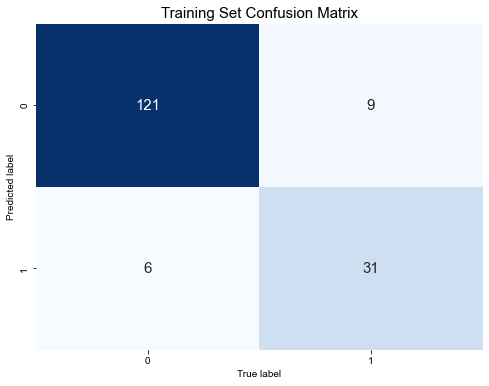

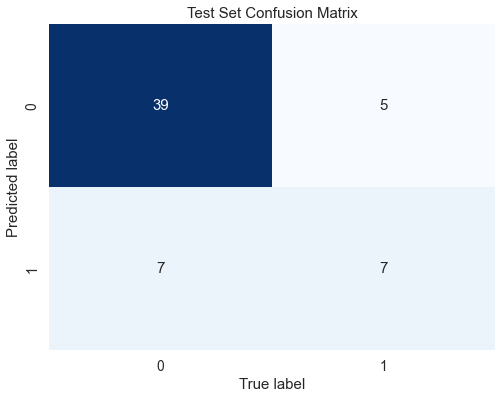

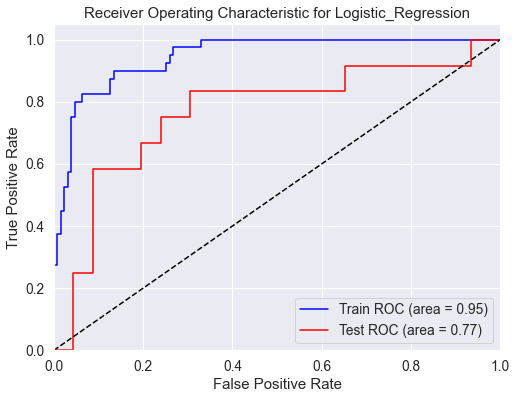

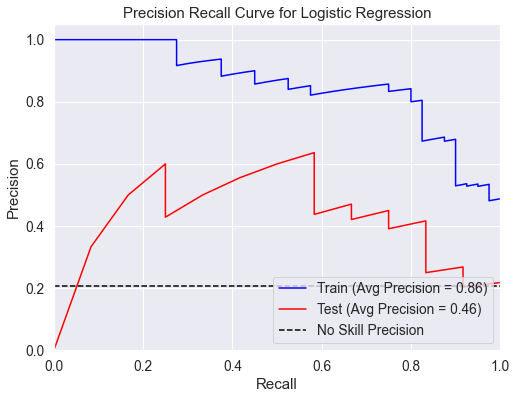

In [11]:
evaluateModel.evaluate_model(model = lr_cv_model,
                             model_name = "Logistic_Regression",
                             output_path = "../output",
                             train = train,
                             test = test)

In [12]:
# It's possible to update the threshold by setting it in the correct pipeline stage: 

#lr_cv_model.bestModel.stages[5].setThreshold(0.4519)
#test_results= lr_cv_model.transform(test)
#lr_cv_model.bestModel.stages[5].getThreshold()

### Train GBT Classifier Pipeline

In [13]:
gbt_cv_model = trainModel.train_gbt_model(num_folds = 5, train = train, features_to_scale = features_to_scale)

22/01/12 21:38:46 WARN DAGScheduler: Broadcasting large task binary with size 1000.9 KiB
22/01/12 21:38:46 WARN DAGScheduler: Broadcasting large task binary with size 1001.4 KiB
22/01/12 21:38:47 WARN DAGScheduler: Broadcasting large task binary with size 1002.1 KiB
22/01/12 21:38:47 WARN DAGScheduler: Broadcasting large task binary with size 1003.0 KiB
22/01/12 21:38:47 WARN DAGScheduler: Broadcasting large task binary with size 1004.9 KiB
22/01/12 21:38:47 WARN DAGScheduler: Broadcasting large task binary with size 1006.4 KiB
22/01/12 21:38:47 WARN DAGScheduler: Broadcasting large task binary with size 1006.9 KiB
22/01/12 21:38:47 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB
22/01/12 21:38:47 WARN DAGScheduler: Broadcasting large task binary with size 1008.6 KiB
22/01/12 21:38:47 WARN DAGScheduler: Broadcasting large task binary with size 1010.2 KiB
22/01/12 21:38:47 WARN DAGScheduler: Broadcasting large task binary with size 1012.0 KiB
22/01/12 21:38:47 WAR

22/01/12 21:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1103.0 KiB
22/01/12 21:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1104.7 KiB
22/01/12 21:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1106.4 KiB
22/01/12 21:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1106.9 KiB
22/01/12 21:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1107.6 KiB
22/01/12 21:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1108.6 KiB
22/01/12 21:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1110.5 KiB
22/01/12 21:38:55 WARN DAGScheduler: Broadcasting large task binary with size 1112.3 KiB
22/01/12 21:38:55 WARN DAGScheduler: Broadcasting large task binary with size 1112.8 KiB
22/01/12 21:38:55 WARN DAGScheduler: Broadcasting large task binary with size 1113.5 KiB
22/01/12 21:38:55 WARN DAGScheduler: Broadcasting large task binary with size 1114.5 KiB
22/01/12 21:38:55 WAR

22/01/12 21:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1209.7 KiB
22/01/12 21:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1211.3 KiB
22/01/12 21:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1212.9 KiB
22/01/12 21:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1213.4 KiB
22/01/12 21:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1214.1 KiB
22/01/12 21:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1215.1 KiB
22/01/12 21:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1217.0 KiB
22/01/12 21:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1218.8 KiB
22/01/12 21:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1219.3 KiB
22/01/12 21:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1220.0 KiB
22/01/12 21:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1221.0 KiB
22/01/12 21:39:04 WAR

22/01/12 21:40:49 WARN DAGScheduler: Broadcasting large task binary with size 1023.8 KiB
22/01/12 21:40:49 WARN DAGScheduler: Broadcasting large task binary with size 1024.4 KiB
22/01/12 21:40:49 WARN DAGScheduler: Broadcasting large task binary with size 1024.9 KiB
22/01/12 21:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1025.5 KiB
22/01/12 21:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1026.3 KiB
22/01/12 21:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1027.6 KiB
22/01/12 21:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1028.9 KiB
22/01/12 21:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1029.5 KiB
22/01/12 21:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1030.0 KiB
22/01/12 21:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1030.5 KiB
22/01/12 21:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1031.4 KiB
22/01/12 21:40:50 WAR

22/01/12 21:40:58 WARN DAGScheduler: Broadcasting large task binary with size 1102.6 KiB
22/01/12 21:40:58 WARN DAGScheduler: Broadcasting large task binary with size 1103.9 KiB
22/01/12 21:40:58 WARN DAGScheduler: Broadcasting large task binary with size 1105.2 KiB
22/01/12 21:40:58 WARN DAGScheduler: Broadcasting large task binary with size 1105.8 KiB
22/01/12 21:40:58 WARN DAGScheduler: Broadcasting large task binary with size 1106.3 KiB
22/01/12 21:40:58 WARN DAGScheduler: Broadcasting large task binary with size 1106.8 KiB
22/01/12 21:40:58 WARN DAGScheduler: Broadcasting large task binary with size 1107.7 KiB
22/01/12 21:40:58 WARN DAGScheduler: Broadcasting large task binary with size 1109.0 KiB
22/01/12 21:40:59 WARN DAGScheduler: Broadcasting large task binary with size 1110.2 KiB
22/01/12 21:40:59 WARN DAGScheduler: Broadcasting large task binary with size 1110.9 KiB
22/01/12 21:40:59 WARN DAGScheduler: Broadcasting large task binary with size 1111.3 KiB
22/01/12 21:40:59 WAR

22/01/12 21:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1181.9 KiB
22/01/12 21:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1182.4 KiB
22/01/12 21:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1182.9 KiB
22/01/12 21:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1183.8 KiB
22/01/12 21:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1185.1 KiB
22/01/12 21:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1186.3 KiB
22/01/12 21:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1186.9 KiB
22/01/12 21:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1187.4 KiB
22/01/12 21:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1188.0 KiB
22/01/12 21:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1188.8 KiB
22/01/12 21:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1190.1 KiB
22/01/12 21:41:08 WAR

22/01/12 21:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1053.1 KiB
22/01/12 21:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1054.3 KiB
22/01/12 21:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1055.0 KiB
22/01/12 21:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1055.4 KiB
22/01/12 21:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1056.0 KiB
22/01/12 21:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1056.8 KiB
22/01/12 21:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1058.1 KiB
22/01/12 21:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1059.4 KiB
22/01/12 21:43:06 WARN DAGScheduler: Broadcasting large task binary with size 1060.1 KiB
22/01/12 21:43:06 WARN DAGScheduler: Broadcasting large task binary with size 1060.5 KiB
22/01/12 21:43:06 WARN DAGScheduler: Broadcasting large task binary with size 1061.1 KiB
22/01/12 21:43:06 WAR

22/01/12 21:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1141.3 KiB
22/01/12 21:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1141.8 KiB
22/01/12 21:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1142.3 KiB
22/01/12 21:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1143.2 KiB
22/01/12 21:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1144.5 KiB
22/01/12 21:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1145.7 KiB
22/01/12 21:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1146.4 KiB
22/01/12 21:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1146.9 KiB
22/01/12 21:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1147.4 KiB
22/01/12 21:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1148.2 KiB
22/01/12 21:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1149.6 KiB
22/01/12 21:43:14 WAR

22/01/12 21:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1017.1 KiB
22/01/12 21:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1019.2 KiB
22/01/12 21:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1019.6 KiB
22/01/12 21:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1020.2 KiB
22/01/12 21:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1021.0 KiB
22/01/12 21:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1022.4 KiB
22/01/12 21:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1024.5 KiB
22/01/12 21:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1025.0 KiB
22/01/12 21:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1025.6 KiB
22/01/12 21:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1026.4 KiB
22/01/12 21:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1027.8 KiB
22/01/12 21:45:42 WAR

22/01/12 21:45:50 WARN DAGScheduler: Broadcasting large task binary with size 1119.9 KiB
22/01/12 21:45:50 WARN DAGScheduler: Broadcasting large task binary with size 1120.8 KiB
22/01/12 21:45:50 WARN DAGScheduler: Broadcasting large task binary with size 1122.2 KiB
22/01/12 21:45:50 WARN DAGScheduler: Broadcasting large task binary with size 1124.5 KiB
22/01/12 21:45:50 WARN DAGScheduler: Broadcasting large task binary with size 1124.9 KiB
22/01/12 21:45:50 WARN DAGScheduler: Broadcasting large task binary with size 1125.5 KiB
22/01/12 21:45:51 WARN DAGScheduler: Broadcasting large task binary with size 1126.3 KiB
22/01/12 21:45:51 WARN DAGScheduler: Broadcasting large task binary with size 1127.7 KiB
22/01/12 21:45:51 WARN DAGScheduler: Broadcasting large task binary with size 1130.0 KiB
22/01/12 21:45:51 WARN DAGScheduler: Broadcasting large task binary with size 1130.5 KiB
22/01/12 21:45:51 WARN DAGScheduler: Broadcasting large task binary with size 1131.0 KiB
22/01/12 21:45:51 WAR

22/01/12 21:45:59 WARN DAGScheduler: Broadcasting large task binary with size 1225.5 KiB
22/01/12 21:45:59 WARN DAGScheduler: Broadcasting large task binary with size 1226.0 KiB
22/01/12 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1226.9 KiB
22/01/12 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1228.3 KiB
22/01/12 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1230.6 KiB
22/01/12 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1231.1 KiB
22/01/12 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1231.8 KiB
22/01/12 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1232.7 KiB
22/01/12 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1234.6 KiB
22/01/12 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1236.3 KiB
22/01/12 21:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1236.8 KiB
22/01/12 21:46:00 WAR

22/01/12 21:48:03 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB
22/01/12 21:48:03 WARN DAGScheduler: Broadcasting large task binary with size 1007.3 KiB
22/01/12 21:48:03 WARN DAGScheduler: Broadcasting large task binary with size 1007.8 KiB
22/01/12 21:48:03 WARN DAGScheduler: Broadcasting large task binary with size 1008.5 KiB
22/01/12 21:48:03 WARN DAGScheduler: Broadcasting large task binary with size 1009.5 KiB
22/01/12 21:48:03 WARN DAGScheduler: Broadcasting large task binary with size 1010.5 KiB
22/01/12 21:48:04 WARN DAGScheduler: Broadcasting large task binary with size 1011.9 KiB
22/01/12 21:48:04 WARN DAGScheduler: Broadcasting large task binary with size 1012.9 KiB
22/01/12 21:48:04 WARN DAGScheduler: Broadcasting large task binary with size 1013.6 KiB
22/01/12 21:48:04 WARN DAGScheduler: Broadcasting large task binary with size 1013.4 KiB
22/01/12 21:48:04 WARN DAGScheduler: Broadcasting large task binary with size 1013.8 KiB
22/01/12 21:48:04 WAR

22/01/12 21:48:12 WARN DAGScheduler: Broadcasting large task binary with size 1079.9 KiB
22/01/12 21:48:12 WARN DAGScheduler: Broadcasting large task binary with size 1080.6 KiB
22/01/12 21:48:12 WARN DAGScheduler: Broadcasting large task binary with size 1080.4 KiB
22/01/12 21:48:12 WARN DAGScheduler: Broadcasting large task binary with size 1080.9 KiB
22/01/12 21:48:12 WARN DAGScheduler: Broadcasting large task binary with size 1081.6 KiB
22/01/12 21:48:13 WARN DAGScheduler: Broadcasting large task binary with size 1082.6 KiB
22/01/12 21:48:13 WARN DAGScheduler: Broadcasting large task binary with size 1083.6 KiB
22/01/12 21:48:13 WARN DAGScheduler: Broadcasting large task binary with size 1085.1 KiB
22/01/12 21:48:13 WARN DAGScheduler: Broadcasting large task binary with size 1086.0 KiB
22/01/12 21:48:13 WARN DAGScheduler: Broadcasting large task binary with size 1086.7 KiB
22/01/12 21:48:13 WARN DAGScheduler: Broadcasting large task binary with size 1086.5 KiB
22/01/12 21:48:13 WAR

22/01/12 21:48:19 WARN DAGScheduler: Broadcasting large task binary with size 1149.7 KiB
22/01/12 21:48:19 WARN DAGScheduler: Broadcasting large task binary with size 1150.7 KiB
22/01/12 21:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1152.1 KiB
22/01/12 21:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1153.1 KiB
22/01/12 21:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1153.8 KiB
22/01/12 21:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1153.6 KiB
22/01/12 21:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1154.1 KiB
22/01/12 21:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1154.8 KiB
22/01/12 21:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1155.8 KiB
22/01/12 21:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1156.8 KiB
22/01/12 21:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1158.2 KiB
22/01/12 21:48:20 WAR

22/01/12 21:48:27 WARN DAGScheduler: Broadcasting large task binary with size 1220.5 KiB
22/01/12 21:48:27 WARN DAGScheduler: Broadcasting large task binary with size 1221.0 KiB
22/01/12 21:48:27 WARN DAGScheduler: Broadcasting large task binary with size 1221.7 KiB
22/01/12 21:48:27 WARN DAGScheduler: Broadcasting large task binary with size 1222.8 KiB
22/01/12 21:48:27 WARN DAGScheduler: Broadcasting large task binary with size 1223.7 KiB
22/01/12 21:48:27 WARN DAGScheduler: Broadcasting large task binary with size 1225.2 KiB
22/01/12 21:48:27 WARN DAGScheduler: Broadcasting large task binary with size 1226.1 KiB
22/01/12 21:48:27 WARN DAGScheduler: Broadcasting large task binary with size 1226.9 KiB
22/01/12 21:48:28 WARN DAGScheduler: Broadcasting large task binary with size 1226.6 KiB
22/01/12 21:48:28 WARN DAGScheduler: Broadcasting large task binary with size 1227.1 KiB
22/01/12 21:48:28 WARN DAGScheduler: Broadcasting large task binary with size 1227.8 KiB
22/01/12 21:48:28 WAR

22/01/12 21:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1292.2 KiB
22/01/12 21:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1293.1 KiB
22/01/12 21:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1293.9 KiB
22/01/12 21:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1293.7 KiB
22/01/12 21:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1294.1 KiB
22/01/12 21:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1294.8 KiB
22/01/12 21:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1295.9 KiB
22/01/12 21:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1296.8 KiB
22/01/12 21:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1298.3 KiB
22/01/12 21:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1299.2 KiB
22/01/12 21:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1300.0 KiB
22/01/12 21:48:36 WAR

22/01/12 21:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1362.8 KiB
22/01/12 21:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1363.8 KiB
22/01/12 21:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1365.3 KiB
22/01/12 21:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1366.2 KiB
22/01/12 21:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1366.9 KiB
22/01/12 21:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1366.7 KiB
22/01/12 21:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1367.2 KiB
22/01/12 21:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1367.9 KiB
22/01/12 21:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1368.9 KiB
22/01/12 21:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1369.9 KiB
22/01/12 21:48:46 WARN DAGScheduler: Broadcasting large task binary with size 1371.4 KiB
22/01/12 21:48:46 WAR

22/01/12 21:51:12 WARN DAGScheduler: Broadcasting large task binary with size 1024.1 KiB
22/01/12 21:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1025.0 KiB
22/01/12 21:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1025.8 KiB
22/01/12 21:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1025.5 KiB
22/01/12 21:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1026.0 KiB
22/01/12 21:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1026.7 KiB
22/01/12 21:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1027.8 KiB
22/01/12 21:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1028.7 KiB
22/01/12 21:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1030.2 KiB
22/01/12 21:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1031.1 KiB
22/01/12 21:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1031.8 KiB
22/01/12 21:51:13 WAR

22/01/12 21:51:20 WARN DAGScheduler: Broadcasting large task binary with size 1094.8 KiB
22/01/12 21:51:20 WARN DAGScheduler: Broadcasting large task binary with size 1095.8 KiB
22/01/12 21:51:20 WARN DAGScheduler: Broadcasting large task binary with size 1097.3 KiB
22/01/12 21:51:20 WARN DAGScheduler: Broadcasting large task binary with size 1098.2 KiB
22/01/12 21:51:20 WARN DAGScheduler: Broadcasting large task binary with size 1098.9 KiB
22/01/12 21:51:20 WARN DAGScheduler: Broadcasting large task binary with size 1098.7 KiB
22/01/12 21:51:20 WARN DAGScheduler: Broadcasting large task binary with size 1099.2 KiB
22/01/12 21:51:21 WARN DAGScheduler: Broadcasting large task binary with size 1099.9 KiB
22/01/12 21:51:21 WARN DAGScheduler: Broadcasting large task binary with size 1100.9 KiB
22/01/12 21:51:21 WARN DAGScheduler: Broadcasting large task binary with size 1101.9 KiB
22/01/12 21:51:21 WARN DAGScheduler: Broadcasting large task binary with size 1103.4 KiB
22/01/12 21:51:21 WAR

22/01/12 21:51:27 WARN DAGScheduler: Broadcasting large task binary with size 1165.8 KiB
22/01/12 21:51:27 WARN DAGScheduler: Broadcasting large task binary with size 1166.2 KiB
22/01/12 21:51:27 WARN DAGScheduler: Broadcasting large task binary with size 1166.9 KiB
22/01/12 21:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1168.0 KiB
22/01/12 21:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1168.9 KiB
22/01/12 21:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1170.4 KiB
22/01/12 21:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1171.3 KiB
22/01/12 21:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1172.1 KiB
22/01/12 21:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1171.8 KiB
22/01/12 21:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1172.3 KiB
22/01/12 21:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1173.0 KiB
22/01/12 21:51:28 WAR

22/01/12 21:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1237.4 KiB
22/01/12 21:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1238.3 KiB
22/01/12 21:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1239.0 KiB
22/01/12 21:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1238.8 KiB
22/01/12 21:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1239.3 KiB
22/01/12 21:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1240.0 KiB
22/01/12 21:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1241.0 KiB
22/01/12 21:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1242.0 KiB
22/01/12 21:51:36 WARN DAGScheduler: Broadcasting large task binary with size 1243.5 KiB
22/01/12 21:51:36 WARN DAGScheduler: Broadcasting large task binary with size 1244.4 KiB
22/01/12 21:51:36 WARN DAGScheduler: Broadcasting large task binary with size 1245.1 KiB
22/01/12 21:51:36 WAR

22/01/12 21:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1307.0 KiB
22/01/12 21:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1308.1 KiB
22/01/12 21:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1309.0 KiB
22/01/12 21:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1310.5 KiB
22/01/12 21:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1311.4 KiB
22/01/12 21:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1312.2 KiB
22/01/12 21:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1311.9 KiB
22/01/12 21:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1312.4 KiB
22/01/12 21:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1313.1 KiB
22/01/12 21:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1314.2 KiB
22/01/12 21:51:44 WARN DAGScheduler: Broadcasting large task binary with size 1315.1 KiB
22/01/12 21:51:44 WAR

22/01/12 21:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1379.1 KiB
22/01/12 21:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1378.9 KiB
22/01/12 21:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1379.3 KiB
22/01/12 21:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1380.1 KiB
22/01/12 21:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1381.1 KiB
22/01/12 21:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB
22/01/12 21:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1383.5 KiB
22/01/12 21:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1384.4 KiB
22/01/12 21:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1385.2 KiB
22/01/12 21:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1384.9 KiB
22/01/12 21:51:53 WARN DAGScheduler: Broadcasting large task binary with size 1385.4 KiB
22/01/12 21:51:53 WAR

22/01/12 21:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1050.2 KiB
22/01/12 21:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1050.7 KiB
22/01/12 21:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1051.5 KiB
22/01/12 21:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1052.9 KiB
22/01/12 21:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1054.4 KiB
22/01/12 21:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1054.9 KiB
22/01/12 21:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1055.4 KiB
22/01/12 21:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1056.2 KiB
22/01/12 21:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1057.6 KiB
22/01/12 21:54:04 WARN DAGScheduler: Broadcasting large task binary with size 1059.3 KiB
22/01/12 21:54:04 WARN DAGScheduler: Broadcasting large task binary with size 1059.8 KiB
22/01/12 21:54:04 WAR

22/01/12 22:18:28 WARN DAGScheduler: Broadcasting large task binary with size 1138.6 KiB
22/01/12 22:18:28 WARN DAGScheduler: Broadcasting large task binary with size 1140.3 KiB
22/01/12 22:18:29 WARN DAGScheduler: Broadcasting large task binary with size 1140.8 KiB
22/01/12 22:18:29 WARN DAGScheduler: Broadcasting large task binary with size 1141.4 KiB
22/01/12 22:18:29 WARN DAGScheduler: Broadcasting large task binary with size 1142.2 KiB
22/01/12 22:18:29 WARN DAGScheduler: Broadcasting large task binary with size 1143.5 KiB
22/01/12 22:18:29 WARN DAGScheduler: Broadcasting large task binary with size 1145.2 KiB
22/01/12 22:18:29 WARN DAGScheduler: Broadcasting large task binary with size 1145.7 KiB
22/01/12 22:18:29 WARN DAGScheduler: Broadcasting large task binary with size 1146.3 KiB
22/01/12 22:18:29 WARN DAGScheduler: Broadcasting large task binary with size 1147.1 KiB
22/01/12 22:18:29 WARN DAGScheduler: Broadcasting large task binary with size 1148.4 KiB
22/01/12 22:18:30 WAR

22/01/12 22:26:55 WARN DAGScheduler: Broadcasting large task binary with size 1021.9 KiB
22/01/12 22:26:55 WARN DAGScheduler: Broadcasting large task binary with size 1022.8 KiB
22/01/12 22:26:55 WARN DAGScheduler: Broadcasting large task binary with size 1023.2 KiB
22/01/12 22:26:55 WARN DAGScheduler: Broadcasting large task binary with size 1023.8 KiB
22/01/12 22:26:55 WARN DAGScheduler: Broadcasting large task binary with size 1024.7 KiB
22/01/12 22:26:55 WARN DAGScheduler: Broadcasting large task binary with size 1025.6 KiB
22/01/12 22:26:55 WARN DAGScheduler: Broadcasting large task binary with size 1026.1 KiB
22/01/12 22:26:55 WARN DAGScheduler: Broadcasting large task binary with size 1027.0 KiB
22/01/12 22:26:56 WARN DAGScheduler: Broadcasting large task binary with size 1027.5 KiB
22/01/12 22:26:56 WARN DAGScheduler: Broadcasting large task binary with size 1028.0 KiB
22/01/12 22:26:56 WARN DAGScheduler: Broadcasting large task binary with size 1029.0 KiB
22/01/12 22:26:56 WAR

22/01/12 22:29:19 WARN DAGScheduler: Broadcasting large task binary with size 1080.9 KiB
22/01/12 22:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1083.0 KiB
22/01/12 22:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1083.5 KiB
22/01/12 22:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1084.0 KiB
22/01/12 22:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1084.8 KiB
22/01/12 22:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1086.2 KiB
22/01/12 22:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1088.4 KiB
22/01/12 22:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1088.8 KiB
22/01/12 22:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1089.4 KiB
22/01/12 22:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1090.2 KiB
22/01/12 22:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1091.6 KiB
22/01/12 22:29:20 WAR

22/01/12 22:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1183.1 KiB
22/01/12 22:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1185.2 KiB
22/01/12 22:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1185.7 KiB
22/01/12 22:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1186.3 KiB
22/01/12 22:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1187.1 KiB
22/01/12 22:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1188.5 KiB
22/01/12 22:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1190.6 KiB
22/01/12 22:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1191.1 KiB
22/01/12 22:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1191.6 KiB
22/01/12 22:29:29 WARN DAGScheduler: Broadcasting large task binary with size 1192.5 KiB
22/01/12 22:29:29 WARN DAGScheduler: Broadcasting large task binary with size 1193.9 KiB
22/01/12 22:29:29 WAR

22/01/12 22:31:54 WARN DAGScheduler: Broadcasting large task binary with size 1003.3 KiB
22/01/12 22:31:54 WARN DAGScheduler: Broadcasting large task binary with size 1004.1 KiB
22/01/12 22:31:54 WARN DAGScheduler: Broadcasting large task binary with size 1004.5 KiB
22/01/12 22:31:54 WARN DAGScheduler: Broadcasting large task binary with size 1005.1 KiB
22/01/12 22:31:54 WARN DAGScheduler: Broadcasting large task binary with size 1005.6 KiB
22/01/12 22:31:54 WARN DAGScheduler: Broadcasting large task binary with size 1006.4 KiB
22/01/12 22:31:54 WARN DAGScheduler: Broadcasting large task binary with size 1007.2 KiB
22/01/12 22:31:54 WARN DAGScheduler: Broadcasting large task binary with size 1007.5 KiB
22/01/12 22:31:54 WARN DAGScheduler: Broadcasting large task binary with size 1007.7 KiB
22/01/12 22:31:55 WARN DAGScheduler: Broadcasting large task binary with size 1008.5 KiB
22/01/12 22:31:55 WARN DAGScheduler: Broadcasting large task binary with size 1009.0 KiB
22/01/12 22:31:55 WAR

22/01/12 22:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1056.1 KiB
22/01/12 22:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/01/12 22:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1056.6 KiB
22/01/12 22:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1057.4 KiB
22/01/12 22:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1057.9 KiB
22/01/12 22:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1058.4 KiB
22/01/12 22:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1058.9 KiB
22/01/12 22:32:02 WARN DAGScheduler: Broadcasting large task binary with size 1059.7 KiB
22/01/12 22:32:02 WARN DAGScheduler: Broadcasting large task binary with size 1060.5 KiB
22/01/12 22:32:02 WARN DAGScheduler: Broadcasting large task binary with size 1060.8 KiB
22/01/12 22:32:02 WARN DAGScheduler: Broadcasting large task binary with size 1061.0 KiB
22/01/12 22:32:02 WAR

22/01/12 22:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1027.3 KiB
22/01/12 22:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1027.8 KiB
22/01/12 22:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1028.6 KiB
22/01/12 22:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1029.4 KiB
22/01/12 22:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1029.7 KiB
22/01/12 22:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1029.9 KiB
22/01/12 22:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1030.7 KiB
22/01/12 22:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1031.2 KiB
22/01/12 22:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1031.7 KiB
22/01/12 22:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1032.3 KiB
22/01/12 22:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1033.1 KiB
22/01/12 22:34:36 WAR

22/01/12 22:34:43 WARN DAGScheduler: Broadcasting large task binary with size 1027.6 KiB
22/01/12 22:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1000.4 KiB
22/01/12 22:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
22/01/12 22:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1002.5 KiB
22/01/12 22:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1003.4 KiB
22/01/12 22:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1003.9 KiB
22/01/12 22:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/01/12 22:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1005.5 KiB
22/01/12 22:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1006.8 KiB
22/01/12 22:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB
22/01/12 22:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1008.1 KiB
22/01/12 22:37:12 WAR

22/01/12 22:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1031.0 KiB
22/01/12 22:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1032.3 KiB
22/01/12 22:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1033.3 KiB
22/01/12 22:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1033.8 KiB
22/01/12 22:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1034.5 KiB
22/01/12 22:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1035.4 KiB
22/01/12 22:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1036.6 KiB
22/01/12 22:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1037.5 KiB
22/01/12 22:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1038.0 KiB
22/01/12 22:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1038.7 KiB
22/01/12 22:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1039.7 KiB
22/01/12 22:39:05 WAR

In [14]:
gbt_cv_model.write().overwrite().save("../models/gbt_model_sample")

In [15]:
gbt_cv_model.avgMetrics

[0.7244771622728358,
 0.7305342101843326,
 0.7332690396835133,
 0.7468567466876017,
 0.7426003635957008,
 0.5762110684420674,
 0.5876030926965042,
 0.5904271306761733,
 0.5775868018756236,
 0.6132115574332243,
 0.470448788881937,
 0.48857571295180696,
 0.533337292998017,
 0.471119560891765,
 0.5054946550085144,
 0.470448788881937,
 0.48857571295180696,
 0.533337292998017,
 0.471119560891765,
 0.5054946550085144]

GBT - Train Set AUROC: 1.0
GBT - Test Set AUROC: 0.786


GBT - Train Average Precision: 1.0
GBT - Test Average Precision: 0.5


GBT - Train No Skill Precision: 0.24
GBT - Test No Skill Precision: 0.207

 ****Classification Report on Train Data***
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       127
           1       1.00      1.00      1.00        40

    accuracy                           1.00       167
   macro avg       1.00      1.00      1.00       167
weighted avg       1.00      1.00      1.00       167


 ****Classification Report on Test Data***
              precision    recall  f1-score   support

           0       0.92      0.76      0.83        46
           1       0.45      0.75      0.56        12

    accuracy                           0.76        58
   macro avg       0.69      0.76      0.70        58
weighted avg       0.82      0.76      0.78        58



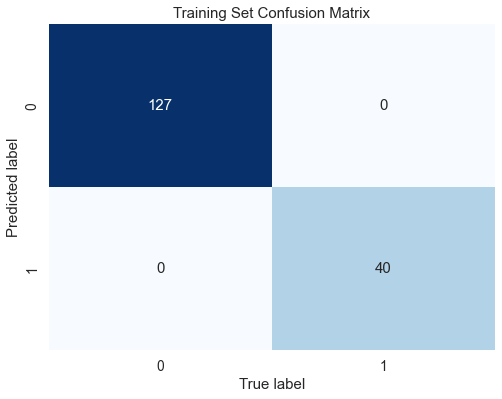

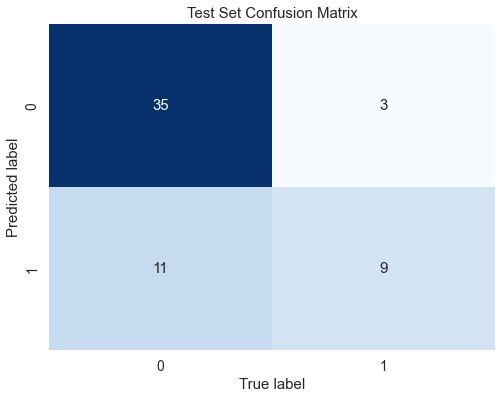

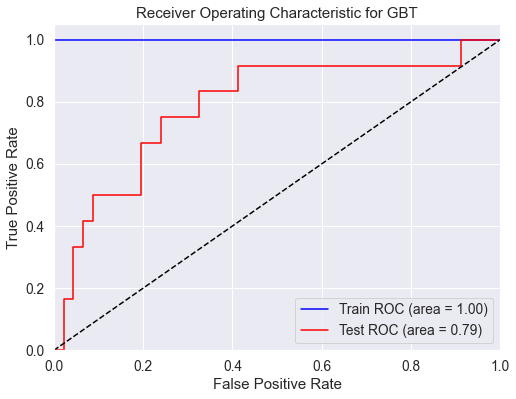

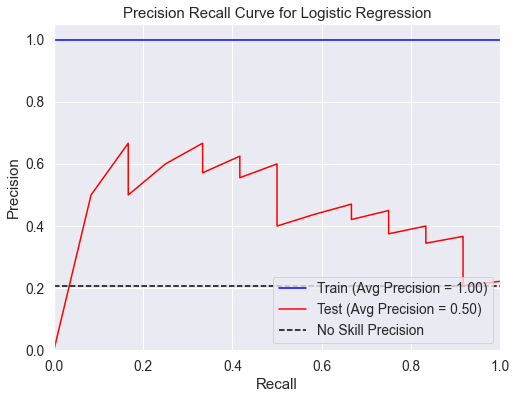

In [16]:
evaluateModel.evaluate_model(gbt_cv_model, "GBT", "../output",train, test)

In [17]:
spark.stop()